# Exploration of NCD topology

Queries to obtain the CSV files:

`graphs.csv`:
`SELECT lbltype, compid, ncd_formula, dist_aggregator, seqpart, seqid_1, seqid_2, seqid_train, lbl, dist FROM PairwiseDistances JOIN Labels USING (lbltype) JOIN Sequences WHERE Labels.seqid = seqid_train AND Sequences.seqid = seqid_1`

`traingraph.csv` :
`SELECT TrainingPairings.lbltype, compid, ncd_formula, seqid_other, seqid_train, TrainingPairings.lbl, ncd_value from TrainingPairings JOIN Sequences ON Sequences.seqid = seqid_other JOIN Labels ON Labels.lbltype = TrainingPairings.lbltype AND Labels.seqid = Sequences.seqid WHERE seqpart > 0`

`labels.csv`:
`SELECT lbltype, seqid, lbl FROM Labels`

`seqs.csv` :
`SELECT seqid, seqpart, GROUP_CONCAT(tokval, " ") AS seq, lbltype, lbl FROM Sequences NATURAL JOIN SequenceValues NATURAL JOIN Alphabet NATURAL JOIN Labels GROUP BY seqid`

In [ ]:
import math
import sqlite3 as sql
import dask.dataframe as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
COMPNAME = 6
NCD_FORMULA = "norm-inf-dist-1"

In [3]:
df = pd.read_csv("graphs.csv")
df = df[(df["compid"] == COMPNAME) & (df["ncd_formula"] == NCD_FORMULA) & (df["seqpart"] == 1)].compute()
df["weight"] = 1.0 / df["dist"]

In [23]:
df

,lbltype,compid,ncd_formula,dist_aggregator,seqpart,seqid_1,seqid_2,lbl,dist,weight
677770,0,6,norm-inf-dist-1,mp,1,90,91,1,1.509215,0.662596
677771,0,6,norm-inf-dist-1,mp,1,91,90,1,1.509215,0.662596
677772,0,6,norm-inf-dist-1,mp,1,90,190,1,1.450336,0.689495
677773,0,6,norm-inf-dist-1,mp,1,190,90,1,1.450336,0.689495
677774,0,6,norm-inf-dist-1,mp,1,90,191,1,1.386243,0.721374
...,...,...,...,...,...,...,...,...,...,...
865233,0,6,norm-inf-dist-1,mp,1,49148,49051,1,1.655263,0.604134
865234,0,6,norm-inf-dist-1,mp,1,49051,49149,1,1.456987,0.686348
865235,0,6,norm-inf-dist-1,mp,1,49149,49051,1,1.456987,0.686348
865280,0,6,norm-inf-dist-1,mp,1,49148,49149,1,1.301724,0.768212


In [4]:
lbls = pd.read_csv("labels.csv").compute()
lbls = { row["seqid"] : row["lbl"] for index, row in lbls.iterrows() }

In [12]:
seqs = pd.read_csv("seqs.csv").set_index("seqid").compute()
seqs

,seqpart,seq,lbltype,lbl
seqid,,,,
0,0,[CLS] you ' re going to puerto rico ? ! im so ...,0,0
1,0,"[CLS] * e hug ##z * after ur last 3 updates , ...",0,0
2,0,[CLS] i think gave merge leak ##y ##fl ##u but...,0,0
3,0,[CLS] got my new replacement laptop today ! so...,0,0
4,0,[CLS] geo ##rdi ##es to go down ? [SEP],0,1
...,...,...,...,...
49149,1,[CLS] ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ...,0,1
49150,2,[CLS] fuck . it ' s only in canada right now ....,0,0
49151,2,[CLS] get 100 followers a day using once you a...,0,1


In [6]:
G = nx.from_pandas_edgelist(df, "seqid_1", "seqid_2", ["weight", "dist", "lbl"])
G_mst = nx.minimum_spanning_tree(G, weight="dist")

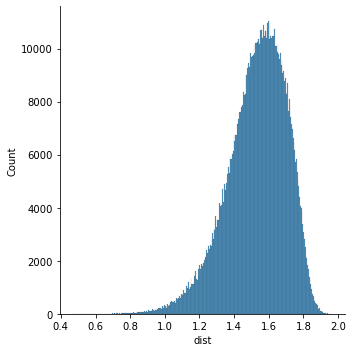

In [80]:
sns.displot(df["dist"])

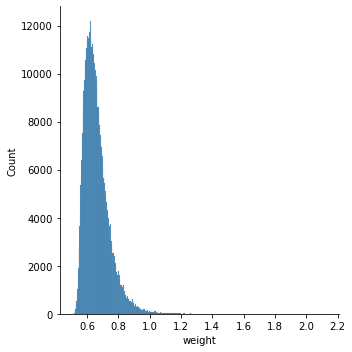

In [81]:
sns.displot(df["weight"])

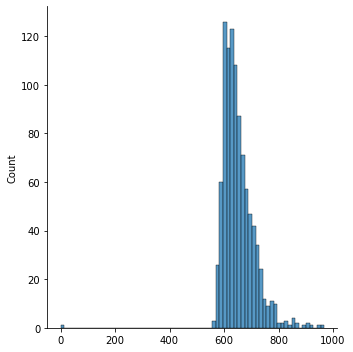

In [82]:
sns.displot(nx.laplacian_spectrum(G))

In [7]:
node_colours = [('blue' if lbls[node] == 0 else 'red') for node in G.nodes()]
edge_opacities = list(nx.get_edge_attributes(G, "weight").values())
edge_opacities = [0.0 if a < 1.0 else 0.2 * (a - 1.0) / 3.0 for a in edge_opacities]

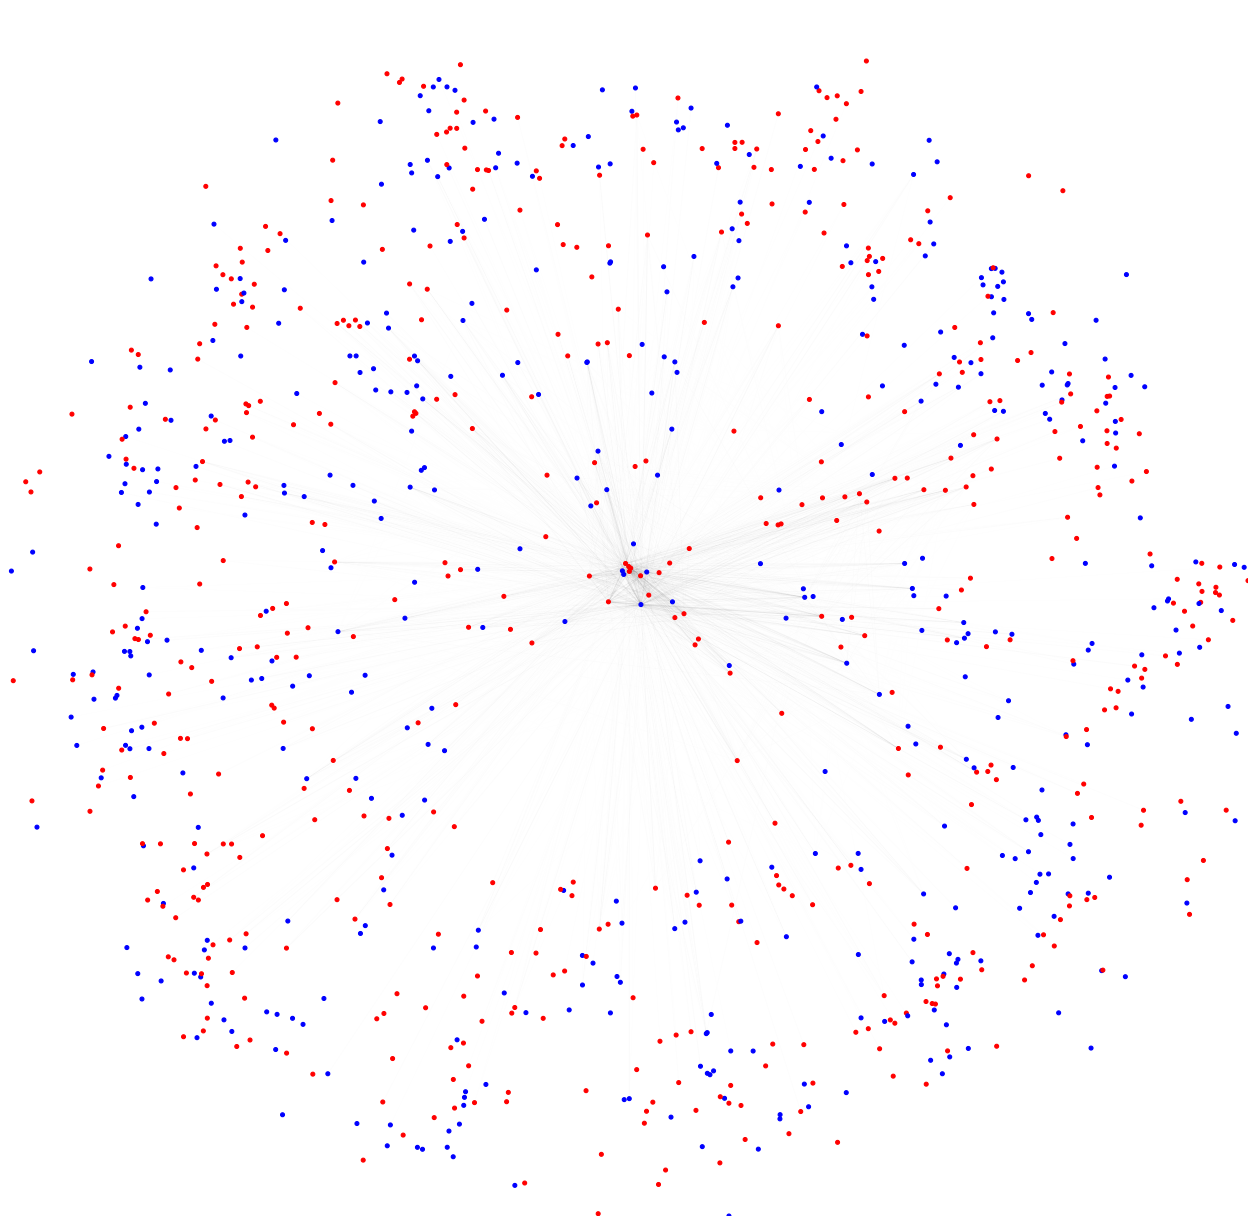

In [84]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G, weight="weight")
nx.draw_networkx_nodes(G, pos, node_shape='.', node_size=50, node_color=node_colours)
nx.draw_networkx_edges(G, pos, alpha=edge_opacities)
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

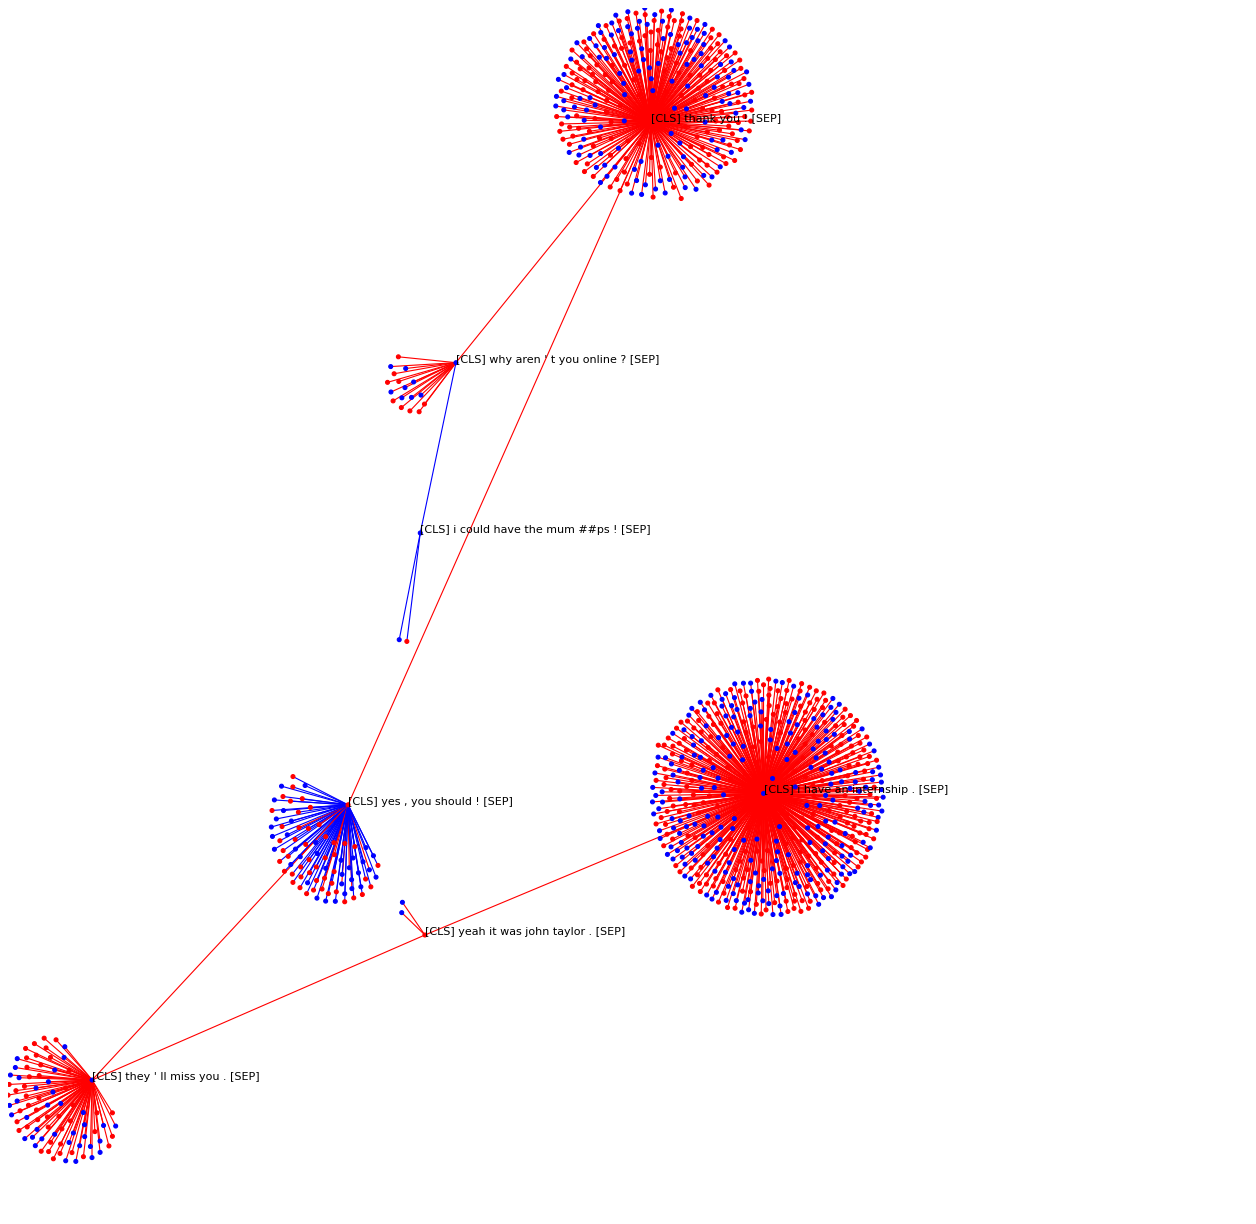

In [30]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G_mst, weight=None)
nx.draw_networkx_nodes(G_mst, pos, node_shape='.', node_size=50, node_color=node_colours)
nx.draw_networkx_edges(
    G_mst, pos,
    edge_color=[('blue' if lbl == 0 else 'red') for lbl in nx.get_edge_attributes(G_mst, "lbl").values()]
)
for seqid in G_mst.nodes():
    if G_mst.degree[seqid] > 1:
        plt.text(pos[seqid][0], pos[seqid][1],
                 seqs[seqs.index == seqid]["seq"].iloc[0])
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [14]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G_mst.nodes():
    # vote on neighbouring edge labels on that node in the MST
    cur_lbls = {}
    for _, _, lbl in G_mst.edges(seqid, data="lbl"):
        if lbl not in cur_lbls:
            cur_lbls[lbl] = 0
        cur_lbls[lbl] += 1

    # get highest vote
    max_count = -1
    max_lbl = None
    for lbl, n in cur_lbls.items():
        if n > max_count:
            max_count = n
            max_lbl = lbl

    if len(G_mst.edges(seqid)) > 1:
        print("Votes for central node", seqid, "with true label", lbls[seqid], "are", cur_lbls, ". Classified as", max_lbl, ".")
        print("Central node reads", seqs[seqs.index == seqid]["seq"].iloc[0])
    conf_matrix[lbls[seqid]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / len(G_mst.nodes()))

Votes for central node 289 with true label 0 are {1: 84} . Classified as 1 .
Central node reads [CLS] they ' ll miss you . [SEP]
Votes for central node 879 with true label 0 are {1: 18, 0: 1} . Classified as 1 .
Central node reads [CLS] why aren ' t you online ? [SEP]
Votes for central node 26437 with true label 1 are {1: 11, 0: 74} . Classified as 0 .
Central node reads [CLS] yes , you should ! [SEP]
Votes for central node 28889 with true label 1 are {1: 295} . Classified as 1 .
Central node reads [CLS] thank you ! [SEP]
Votes for central node 35074 with true label 1 are {1: 4} . Classified as 1 .
Central node reads [CLS] yeah it was john taylor . [SEP]
Votes for central node 37732 with true label 0 are {0: 3} . Classified as 0 .
Central node reads [CLS] i could have the mum ##ps ! [SEP]
Votes for central node 39706 with true label 0 are {1: 501} . Classified as 1 .
Central node reads [CLS] i have an internship . [SEP]
[[32, 427], [46, 481]]
Accuracy: 0.5202839756592292


In [15]:
df2 = pd.read_csv("traingraph.csv")
df2 = df2[(df2["compid"] == COMPNAME) & (df2["ncd_formula"] == NCD_FORMULA)].compute()

In [16]:
# add training labels to `lbls`
# and also keep track of which are training nodes
train_nodes = set()
for index, (seqid, lbl) in df2[["seqid_train", "lbl"]].iterrows():
    lbls[seqid] = lbl
    train_nodes.add(seqid)

In [17]:
G2 = nx.from_pandas_edgelist(df2, "seqid_other", "seqid_train", ["ncd_value", "lbl"])
G2_mst = nx.minimum_spanning_tree(G2, weight="ncd_value")

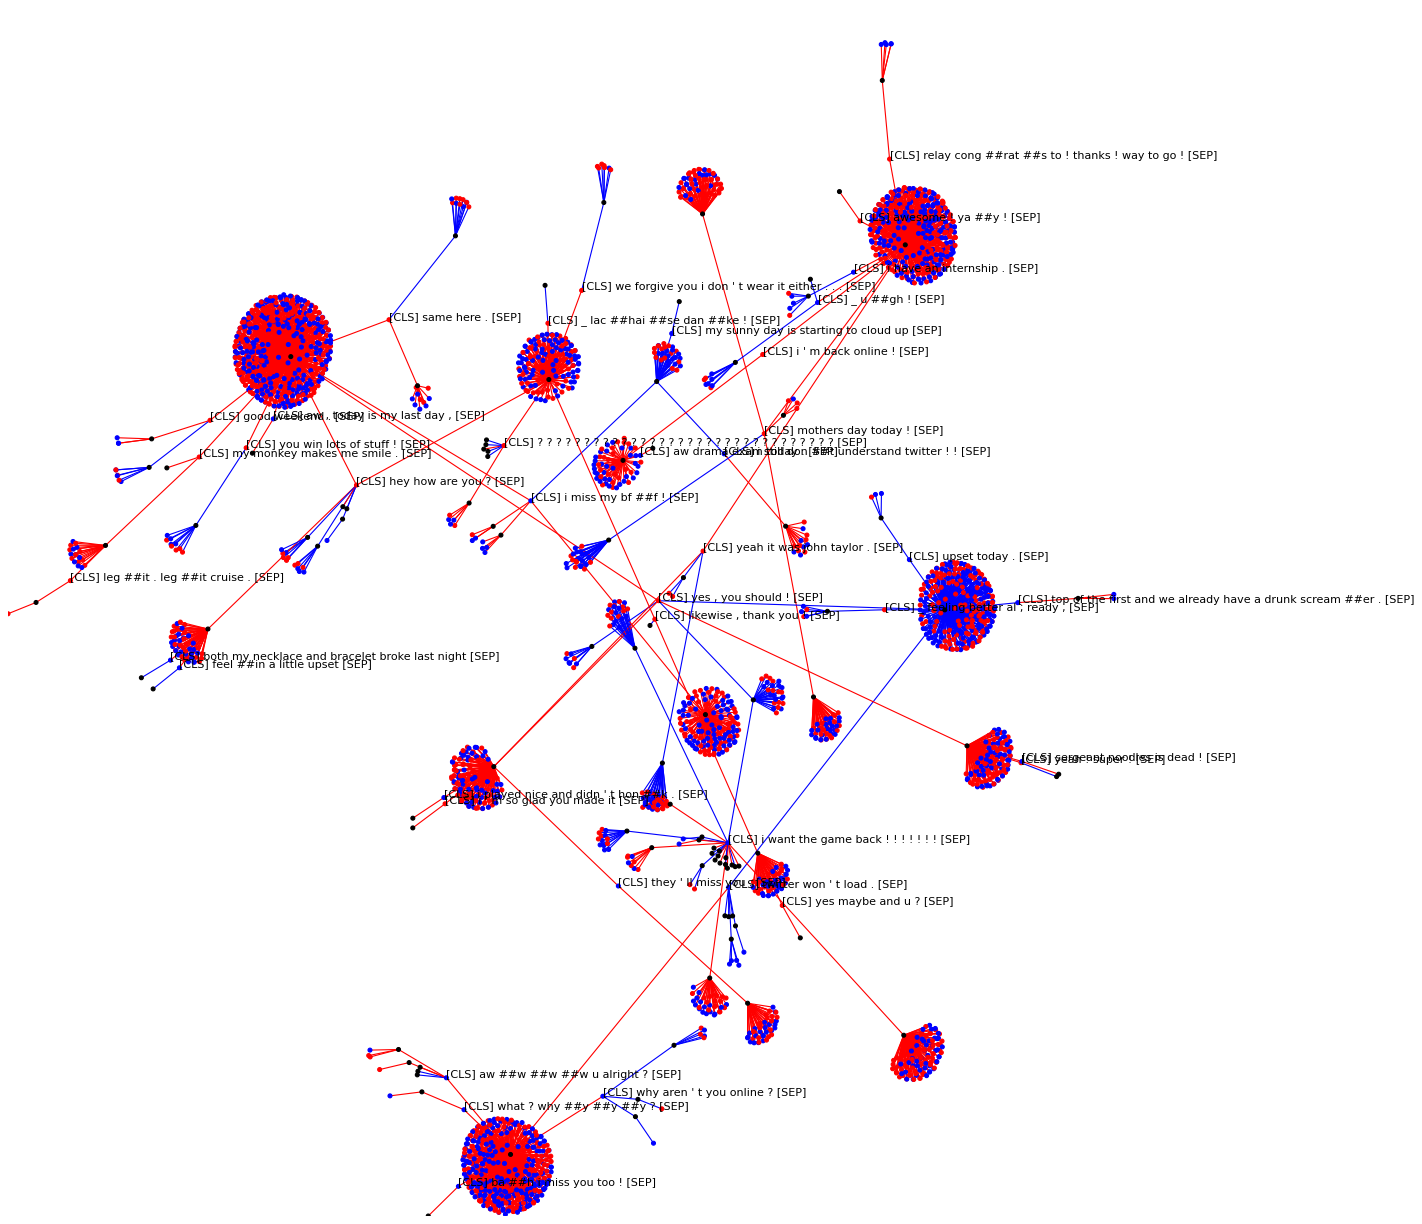

In [31]:
node_colours2 =[
    ('blue' if lbls[node] == 0 else 'red') if node not in train_nodes
    else 'black'
    for node in G2.nodes()
]

plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G2_mst, weight=None)
nx.draw_networkx_nodes(G2_mst, pos, node_size=50, node_shape='.',
                       node_color=node_colours2)
nx.draw_networkx_edges(
    G2_mst, pos,
    edge_color=[('blue' if lbl == 0 else 'red') for lbl in nx.get_edge_attributes(G2_mst, "lbl").values()]
)
for seqid in G2_mst.nodes():
    if G2_mst.degree[seqid] > 1 and seqs[seqs.index == seqid]["seqpart"].iloc[0] > 0:
        plt.text(pos[seqid][0], pos[seqid][1],
                 seqs[seqs.index == seqid]["seq"].iloc[0])
xmax = max(abs(xx) for xx, yy in pos.values())
ymax = max(abs(yy) for xx, yy in pos.values())
plt.xlim(-xmax, xmax)
plt.ylim(-ymax, ymax)
plt.show()

In [32]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G2_mst.nodes():
    if seqid in train_nodes:
        continue  # skip training nodes

    # vote on neighbouring edge labels on that node in the MST
    cur_lbls = {}
    for _, _, lbl in G2_mst.edges(seqid, data="lbl"):
        if lbl not in cur_lbls:
            cur_lbls[lbl] = 0
        cur_lbls[lbl] += 1

    # get highest vote
    max_count = -1
    max_lbl = None
    for lbl, n in cur_lbls.items():
        if n > max_count:
            max_count = n
            max_lbl = lbl

    conf_matrix[lbls[seqid]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / len(G2_mst.nodes()))

[[276, 1160], [261, 1260]]
Accuracy: 0.5024533856722276


In [20]:
G3a = nx.from_pandas_edgelist(df2[df2["lbl"] == 0], "seqid_other", "seqid_train", ["ncd_value"])
G3a_mst = nx.minimum_spanning_tree(G3a, weight="ncd_value")

G3b = nx.from_pandas_edgelist(df2[df2["lbl"] == 1], "seqid_other", "seqid_train", ["ncd_value"])
G3b_mst = nx.minimum_spanning_tree(G3b, weight="ncd_value")

In [22]:
# count: conf_matrix[true][predicted]
conf_matrix = [[0, 0], [0, 0]]

for seqid in G3a_mst.nodes():
    if seqid in train_nodes:
        continue  # skip training nodes

    degree_a, degree_b = len(G3a_mst.edges(seqid)), len(G3b_mst.edges(seqid))
    if degree_a > degree_b:
        max_lbl = 0
    else:
        max_lbl = 1

    if abs(degree_a - degree_b) > 1:
        print("Decisive node seqid=", seqid, "had degrees", degree_a, degree_b, "with true label", lbls[seqid])
        print("Decisive node reads", seqs[seqs.index == seqid]["seq"].iloc[0])
        conf_matrix[lbls[seqid]][max_lbl] += 1

print(conf_matrix)
print("Accuracy:", (conf_matrix[0][0] + conf_matrix[1][1]) / sum(conf_matrix[0] + conf_matrix[1]))

Decisive node seqid= 879 had degrees 4 1 with true label 0
Decisive node reads [CLS] why aren ' t you online ? [SEP]
Decisive node seqid= 3331 had degrees 1 3 with true label 1
Decisive node reads [CLS] my monkey makes me smile . [SEP]
Decisive node seqid= 4505 had degrees 2 4 with true label 1
Decisive node reads [CLS] mothers day today ! [SEP]
Decisive node seqid= 5987 had degrees 1 4 with true label 0
Decisive node reads [CLS] i miss my bf ##f ! [SEP]
Decisive node seqid= 17411 had degrees 6 2 with true label 0
Decisive node reads [CLS] twitter won ' t load . [SEP]
Decisive node seqid= 49149 had degrees 5 3 with true label 1
Decisive node reads [CLS] ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? [SEP]
[[2, 1], [1, 2]]
Accuracy: 0.6666666666666666
